<h1 style="text-align:center"> Exploring and Predicting Characteristics of Japanese Newspaper Headlines </h1> 
 <h2 style="text-align:center"> <i>STA208 Final Project (Spring 2017)</i> </h2> 
 <h3 style="text-align:center"> <i>Tzu-ping Liu and Gento Kato</i> </h3> 


[<h5 style="text-align:center"> Back to Summary Notebook </h5>](STA208_Project_Summary.ipynb)

<h1 style="text-align:center"> Section V </h1>
<h1 style="text-align:center"> <i>Predicting Negative Sentiments in Newspaper Headlines</i> </h1>

In [27]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In this section, we use supervised learning methods to predict the appearnce of negative sentiment in newspaper headlines. Using the word appearnce matrix data, we learn manually-coded negative sentiment (dichotomous category of 1 = negative and 0 = positive/neutral). Only 1000 cases in the full dataset have manual codes (See [Section II](STA208_Data_Description.ipynb) for data details). Therefore, we use randomly selected 80% of coded cases (or 800 cases) as trainig set to tune parameter values for each method [Subsection 2], and assess their performance on remaining 20% of coded cases (or 200 cases) [Subsection 3]. In the last subsection, we use several well-performed methods to machine-code negative sentiment in the full original dataset. The given codes are used in following sections to conduct further assessment on data.

## 1. Prepare Datasets and Methods

### 1.1 Import Required Modules

To start with, we import python modules that are necessary for the analysis. We use <code>numpy</code>, <code>pandas</code> for the data manipulation, <code>sklearn</code> for various classification methods, and <code>matplotlib</code> for result visualization. Also, the session is temporarilly saved by using <code>shelve</code> module. Lastly, we import user-defined functions from <code>gentokfunc.py</code> file in <code>codes</code> directory. 

In [97]:
#%reset

# Computation Timer
from timeit import default_timer as trec

## Data Mining
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Classification Method
from sklearn import preprocessing, neighbors ## KNN
import sklearn.linear_model as skl_lm ## Linear Methods (Logit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis ## Linear Discricimant Analysis
from sklearn.svm import SVC ## Support Vector Machine 
#from sklearn.naive_bayes import BernoulliNB ## Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier ## Meta-Methods

## Model Selection and Metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.metrics import auc, roc_auc_score, average_precision_score

## User Defined Classification Functions
import sys; sys.path.insert(0, '../codes/') ## If codes path not on sys.path
import gentokfunc as gk; gk = reload(gk) # This is the file for user defined functions
from gentokfunc import MidpointNormalize # class for plotting validation result

## Saving & Loading Objects
import shelve

### 1.2 Load Data

The original data in use are <code>alldata_traincode_170510.csv</code> (for negative sentiment coding) and <code>allWrdMat10.csv.gz</code> (for word frequency matrix). Both data are stored in <code>data</code> folder located in the highest level of this project (not <code>data_public</code> folder). Check [Section II](STA208_Data_Description.ipynb) for more data details. 

### 1.3 Create Training Set and Test Set

From the original data, we first extract 1000 rows that have values for manually-coded negative sentiment (1 = negative, 0 = positive/neutral). Then, to conduct and assess classification methods in following subsections, we split the coded data into training set and test set, with test set being 30% of the coded data. The below table describes the manual-coding distribution in training set and test set. In each dataset, roughly 30% of headlines are coded as negative (=1) and remaining 70% are coded as positive or neutral (=0).

In [48]:
## Import Data
alldata = pd.read_csv("../../data/alldata_traincode_170510.csv", encoding='CP932')
allWrdMat10 = pd.read_csv("../../data/allWrdMat10.csv.gz", encoding='CP932')
## Set X and y for Classification
targetx = allWrdMat10
targety = alldata

In [49]:
# Create Design Matrix
X = np.array(targetx.loc[targety['train'] == 1,:])
y = np.array(targety.loc[targety['train'] == 1,'codeN'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=237843)

In [50]:
pd.DataFrame({'train':np.array(pd.Series(y_train).value_counts()),
             'test':np.array(pd.Series(y_test).value_counts())}, 
             index = ["0: Positive/Neutral", "1: Negative"], 
             columns = ['train','test']).transpose()

,0: Positive/Neutral,1: Negative
train,563,237
test,137,63


## 2. Tune Parameter Values on Training Set

Using the training set generated in the previous subsection, we fit various classification methods to the given dataset. Those methods include K nearest means (KNN), logistic regression with ridge penalty, linear discriminant analysis (LDA), support vector machine with RBF kernel (SVM-RBF), decision tree, bagging with decision tree, random forest, and boosting (Adaboost) with deicision tree. 

&nbsp;&nbsp;&nbsp;&nbsp; In this subsection, we describe the process of tuning parameters for each classification method, based on accuracy score. Otherwise noted, optimal parameter values are assessed with 5-fold cross validation using the training set.  The classification results on test set are compared and evaluated in the next subsection. 

### 2.1 K Nearest Neighbors (KNN)

In K nearest neighbors method, the parameter of interest is $k$, the number of neightbors to consider in the estimation. We consider the total of 25 parameter values $k \in  \{1,3,5,...,45,47,49\}$. 

The code and computation time for the optimization is shown as follows: 

In [280]:
## Classifier
knn = neighbors.KNeighborsClassifier() ##knn estimation

## Tune k 

start = trec()
#params = {'n_neighbors':[1,5,10,50,100,200,500]}
params = {'n_neighbors':np.arange(1,51,2).tolist()}
optparam_knn, optscore_knn, values_knn, scores_knn = gk.class_optparam(X_train, y_train, knn, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 184.838 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [281]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_knn:
    print i, optparam_knn[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_knn)

From 5-Fold Cross Validation, the best parameter values are: 

n_neighbors [11, 19]

The corresponding accuracy score is 0.70750


The accuracy scores for the considered set of paremeter values can be plotted as follows:

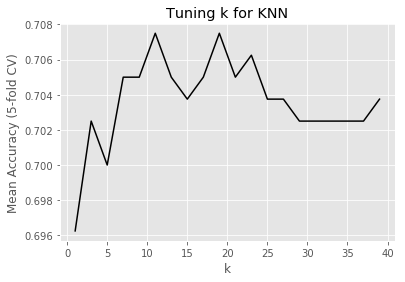

In [365]:
# Plotting Accuracy Score by k
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(values_knn, scores_knn, 'k-')
plt.title('Tuning k for KNN')
plt.xlabel('k')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above plot, it can be seen that the relationship between classification performance and $k$ is not very smooth, while $k$ outside of the above range (i.e., $k > 40$) always give worse performance than the best $k$ in presnted range. There are two optimal parameter values for KNN: $k = \{11,19\}$. We then refit these two models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for each estimation is presented below:

In [524]:
## On Test Set
start = trec()
knn1 = neighbors.KNeighborsClassifier(n_neighbors = 11) # Optimal k = 11
knn1fpr, knn1tpr, knn1rocauc, knn1prec, knn1rec, knn1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, knn1)
time_knn1 = trec() - start
print('Computation time is %0.3f seconds' % time_knn1)

Computation time is 2.339 seconds


In [525]:
## On Test Set
start = trec()
knn2 = neighbors.KNeighborsClassifier(n_neighbors = 19) # Optimal k = 19
knn2fpr, knn2tpr, knn2rocauc, knn2prec, knn2rec, knn2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, knn2)
time_knn2 = trec() - start
print('Computation time is %0.3f seconds' % time_knn2)

Computation time is 2.286 seconds


### 2.2 Logistic Regression (With Newton Conjugate Solver & Ridge Penalty)

In logistic regression, we can optimize the size of ridge penalty $\lambda$. In <code>scikit-learn</code> implementation of logistic regression, $C$ parameter is given as the inverse of $\lambda$ (larger $C$ indicates smaller penalty).  We consider the total of 10 parameter values $C \in  \{0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000\}$. 

The code and computation time for the optimization is shown as follows: 

In [289]:
## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## Tune C
start = trec()
params = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
#params = {'C':np.arange(1,51,1).tolist()}
optparam_logit, optscore_logit,values_logit,scores_logit = gk.class_optparam(X_train, y_train, logit, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 58.868 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [290]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_logit:
    print i, optparam_logit[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_logit)

From 5-Fold Cross Validation, the best parameter values are: 

C [1000.0]

The corresponding accuracy score is 0.77125


The accuracy scores for the considered set of paremeter values can be plotted as follows:

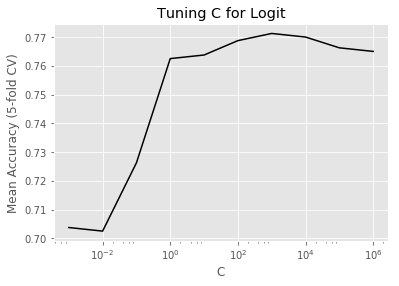

In [291]:
# Plotting Accuracy Score by C
plt.rcParams["figure.figsize"] = (6,4)
plt.semilogx(values_logit, scores_logit, 'k-')
#plt.plot(values_logit, scores_logit, 'k-')
plt.title('Tuning C for Logit')
plt.xlabel('C')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above plot, large penalty $C < 10$ substantially decreases the classification performance. Smaller penalty $C > 10$ generally give the good performance, and the optimal penalty size for logistic regression is $C = 1000$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [528]:
## On Test Set with C =　1000
start = trec()
logit = skl_lm.LogisticRegression(solver='newton-cg', C = 1000)
logitfpr, logittpr, logitrocauc, logitprec, logitrec, logitprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, logit)
time_logit = trec() - start
print('Computation time is %0.3f seconds' % time_logit)

Computation time is 1.678 seconds


### 2.3 Linear Discriminant Analysis (LDA)

In linear discriminant analysis, <code>scikit-learn</code> implementation provides the parameter called $shrinkage$. According to its documentation, "a value of 0 corresponds to no shrinkage (which means the empirical covariance matrix will be used) and a value of 1 corresponds to complete shrinkage (which means that the diagonal matrix of variances will be used as an estimate for the covariance matrix)". Given this nature of the parameter, we consider the total of 11 parameter values $shrinkage \in  \{0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0\}$. 

The code and computation time for the optimization is shown as follows: 

In [328]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="lsqr") ## The default svd solver does not accept shrinkage

## Tune Shrinkage parameter
start = trec()
params = {'shrinkage':np.arange(0.0,1.1,0.1).tolist()}
optparam_lda, optscore_lda,values_lda,scores_lda = gk.class_optparam(X_train, y_train, lda, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 19755.958 seconds


From the optimization, the optimal parameter values are estimated as follows (note that optimization takes excessively long time):

In [329]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_lda:
    print i, optparam_lda[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_lda)

From 5-Fold Cross Validation, the best parameter values are: 

shrinkage [0.8]

The corresponding accuracy score is 0.77750


The accuracy scores for the considered set of paremeter values can be plotted as follows:

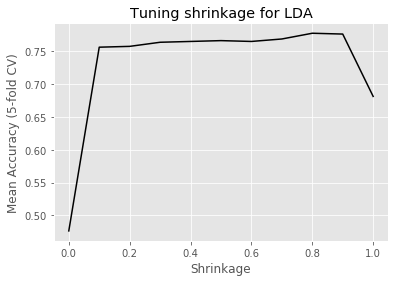

In [330]:
# Plotting Accuracy Score by shrinkage
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_lda, scores_lda, 'k-')
plt.title('Tuning shrinkage for LDA')
plt.xlabel('Shrinkage')
plt.ylabel('Mean Accuracy (5-fold CV)')
plt.show()

From the above plot, it is clear that setting $shrinkage \in (0, 1)$ substantially improves the classification performance. The optimal parameter value in LDA is $shrinkage = 0.8$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [529]:
start = trec()
## On Test Set
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage = 0.8) 
ldafpr, ldatpr, ldarocauc, ldaprec, ldarec, ldaprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, lda)
time_lda = trec() - start
print('Computation time is %0.3f seconds' % time_lda)

Computation time is 396.365 seconds


### 2.4 Support Vector Machine with RBF Kernel (SVM-RBF)

In <code>scikit-learn</code> implementation of support vector machine with RBF kernel, there are two parameters to optimize. The first parameter is $C$, which is equal to the inverse of ridge penalty as in logistic regression. The second paramter is $gamma$, which is the kernel coefficient. We consider following parameter values in optimization:
 * $C \in \{0.01,0.1,1,10,100,1000,10000\}$
 * $gamma \in \{0.00001,0.0001,0.001,0.01, 0.1, 1,10\}$
 
The code and computation time for the optimization is shown as follows: 

In [319]:
# Tune C and gamma for SVC with RBF Kernel
start = trec()
params = {'C': [0.01,0.1,1,10,100,1000,10000], 'gamma':[0.00001,0.0001,0.001,0.01, 0.1, 1,10]}
svmcl = SVC(kernel='rbf', probability=True)
optparam_svm, optscore_svm, values1_svm, values2_svm, scores_svm = gk.class_optparam(X_train, y_train, svmcl, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 4261.951 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [320]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_svm:
    print i, optparam_svm[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_svm)

From 5-Fold Cross Validation, the best parameter values are: 

C [100.0]
gamma [0.01]

The corresponding accuracy score is 0.76375


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

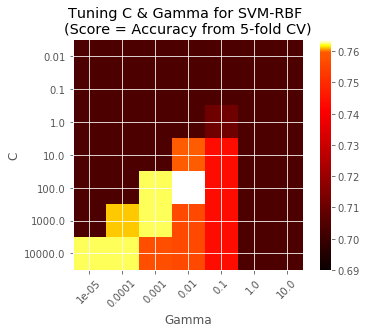

In [514]:
## Plot Validation Result
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_svm, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.69, midpoint=0.76))
plt.xlabel('Gamma'); plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(values2_svm)), values2_svm, rotation=45)
plt.yticks(np.arange(len(values1_svm)), values1_svm)
plt.title('Tuning C & Gamma for SVM-RBF \n(Score = Accuracy from 5-fold CV)')
plt.show()

In the above image plot, there is a clear patterns of convergence in optimal parameter value combination. The optimal parameter values in SVM-RBF are $C = 100$ and $gamma = 0.01$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [530]:
start = trec()
## On Test Set
svmcl = SVC(probability=True, C = 100, gamma = 0.01)
svmfpr, svmtpr, svmrocauc, svmprec, svmrec, svmprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, svmcl)
time_svm = trec() - start
print('Computation time is %0.3f seconds' % time_svm)

Computation time is 34.964 seconds


### 2.5 Decision Tree

In decision tree, we optimize the maximum search depth in each tree created. In <code>scikit-learn</code> implementation, this parameter is called $max\_depth$. We consider the total of 8 parameter values of $max\_depth \in  \{2,3,5,7,10,15,30,50\}$. Also, our dataset has unbalanced training code of ratio roughly 3:7. It is known that decision tree is easily affected by the unbalanced nature of the training code. To (at least partially) adjust for this unbalanced nature, we use $class\_weight = "unbalanced"$ option. This option adds weight to the trainig code values that is "inversely proportional to class frequencies in the input data" (from <code>scikit-learn</code> documentation). 

The code and computation time for the optimization is shown as follows: 

In [468]:
## Decision Tree 
dt = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced")

## Tune Maximum Depth parameter
start = trec()
params = {'max_depth':[2,3,5,7,10,15,30,50]}
optparam_dt, optscore_dt,values_dt,scores_dt = gk.class_optparam(X_train, y_train, dt, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 16.338 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [487]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_dt:
    print i, optparam_dt[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_dt)

From 5-Fold Cross Validation, the best parameter values are: 

max_depth [3, 10]

The corresponding accuracy score is 0.74875


The accuracy scores for the considered set of paremeter values can be plotted as follows:

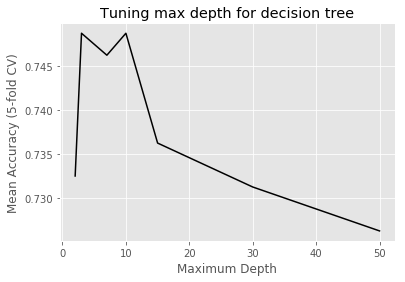

In [470]:
# Plotting Accuracy Score by shrinkage
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_dt, scores_dt, 'k-')
plt.title('Tuning max depth for decision tree')
plt.xlabel('Maximum Depth')
plt.ylabel('Mean Accuracy (5-fold CV)')

plt.show()

From the above plot, the optimal maximum search depth for decision tree method are $3$ and $10$. We then refit these models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for each estimation is presented below:

In [531]:
start = trec()
## Decision Tree 
dt1 = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced", max_depth = 3)
## On Test Set
dt1fpr, dt1tpr, dt1rocauc, dt1prec, dt1rec, dt1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, dt1)
time_dt1 = trec() - start
print('Computation time is %0.3f seconds' % time_dt1)

Computation time is 0.300 seconds


In [532]:
start = trec()
## Decision Tree 
dt2 = DecisionTreeClassifier(random_state = 13453, class_weight = "balanced", max_depth = 10)
## On Test Set
dt2fpr, dt2tpr, dt2rocauc, dt2prec, dt2rec, dt2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, dt2)
time_dt2 = trec() - start
print('Computation time is %0.3f seconds' % time_dt2)

Computation time is 0.511 seconds


### 2.6 Bagging with Decision Tree

In ensemble classification method, bagging, with decision tree, we try to optimize the number of (decision tree) estimators to average. In <code>scikit-learn</code> implementation, this parameter is called $n\_estimators$. We consider the total of 10 parameter values of $n\_estimators \in  \{10,20,30,40,50,60,70,80,90,100\}$. 

The code and computation time for the optimization is shown as follows:

In [98]:
## Bagging
start = trec()
params = {'n_estimators': np.arange(10,101,10).tolist()} 
bag = BaggingClassifier(random_state = 23465, n_jobs = -1, oob_score = True)
optparam_bag, optscore_bag, values_bag, scores_bag = gk.class_optparam(X_train, y_train, bag, params = params) #, val_method = 'OOB'
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 531.045 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [99]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_bag:
    print i, optparam_bag[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_bag)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [10]

The corresponding accuracy score is 0.75250


The accuracy scores for the considered set of paremeter values can be plotted as follows:

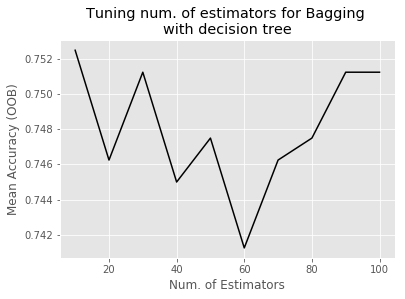

In [100]:
# Plotting Accuracy Score by n_estimators
plt.rcParams["figure.figsize"] = (6,4)
#plt.semilogx(values, scores, 'k-')
plt.plot(values_bag, scores_bag, 'k-')
plt.title('Tuning num. of estimators for Bagging \nwith decision tree')
plt.xlabel('Num. of Estimators')
plt.ylabel('Mean Accuracy (OOB)')

plt.show()

From the above plot, the optimal number of estimators to average in bagging is $100$. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [104]:
start = trec()
## Bagging
bag = BaggingClassifier(random_state = 23465, n_jobs = -1, n_estimators = 10)
## On Test Set
bagfpr, bagtpr, bagrocauc, bagprec, bagrec, bagprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, bag)
time_bag = trec() - start
print('Computation time is %0.3f seconds' % time_bag)

Computation time is 4.085 seconds


### 2.7 Random Forest 

In <code>scikit-learn</code> implementation of Random Forest classification, there are two major parameters to optimize. The first parameter is $n\_estimators$, which is the number of trees to grow in each estimation. The second paramter is $max\_features$, which is the maximum number of features (words/variables) to consider in each splitting decision, represented by the proportion or function of number of features. We consider following parameter values in optimization:
 * $n\_estimators \in \{10,50,100,200,500\}$
 * $max\_features \in \{\mbox{log},\mbox{square root},0.1,0.5,\mbox{All} \}$
 
The code and computation time for the optimization is shown as follows (out-of-bag accuracy is used for validation): 

In [149]:
## Random Forest
## Tune # of trees to grow and number of features to consider
start = trec()
params = {'n_estimators': [10,50,100,200,500],'max_features': ["log2","sqrt",None]} # 0.001,0.01,0.05,0.1,0.2,0.5,1. #
rf = RandomForestClassifier(random_state = 7899993, n_jobs=2, oob_score = True)
optparam_rf, optscore_rf, values1_rf, values2_rf, scores_rf = gk.class_optparam(X_train, y_train, rf, params = params) #, val_method = 'OOB'
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 1428.727 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [150]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_rf:
    print i, optparam_rf[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [100]
max_features ['sqrt']

The corresponding accuracy score is 0.75375


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

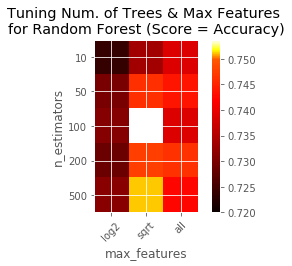

In [152]:
values2_rf = ["log2",'sqrt',"all"]
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.72, midpoint=0.75))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_rf)), values2_rf, rotation=45)
plt.yticks(np.arange(len(values1_rf)), values1_rf)
plt.title('Tuning Num. of Trees & Max Features \nfor Random Forest (Score = Accuracy)')
plt.show()

From the above, for the random forest classifier, the optimal number of trees is $100$, and optimal maximum number of features is **square root** of number of features. We then refit this model on training set and use it to predict codes in test set. The outcome will be used in the next subsection. Computation time for the estimation is presented below:

In [132]:
## On Test Set
start = trec()
rf = RandomForestClassifier(n_estimators=100, max_features = "sqrt", random_state = 7899993, n_jobs=2)
rffpr, rftpr, rfrocauc, rfprec, rfrec, rfprauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, rf)
time_rf = trec() - start
print('Computation time is %0.3f seconds' % time_rf)

Computation time is 3.608 seconds


### 2.8 Boosting (Adaboost) with Decision Tree

In <code>scikit-learn</code> implementation of Adaboost, one of boosting algorithm, with decision tree classifier, there are two major parameters to optimize. The first parameter is $n\_estimators$ (NE), which is the (maximum) number of (decision tree) estimators to consider. The second paramter is $learning\_rate$ (LR), which is the shrinkage factors for the contribution of each classifier. We consider following parameter values in optimization:

 * $n\_estimators \in \{10,50,100,200,500\}$
 * $learning\_rate \in \{0.2,0.4,0.6,0.8,1.0 \}$
 
The code and computation time for the optimization is shown as follows: 

In [495]:
## Adaboost
## Tune # of estimators and learning rate 
start = trec()
params = {'n_estimators': [10,50,100,200,500],'learning_rate':[0.2,0.4,0.6,0.8,1.]}
boost = AdaBoostClassifier(random_state = 7899993)
optparam_boost, optscore_boost, values1_boost, values2_boost, scores_boost = gk.class_optparam(X_train, y_train, boost, params = params)
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 1812.685 seconds


From the optimization, the optimal parameter values are estimated as follows:

In [496]:
print 'From 5-Fold Cross Validation, the best parameter values are: \n' 
for i in optparam_boost:
    print i, optparam_boost[i]
print('\nThe corresponding accuracy score is %0.5f' % optscore_rf)

From 5-Fold Cross Validation, the best parameter values are: 

n_estimators [50, 200]
learning_rate [0.8, 0.6]

The corresponding accuracy score is 0.75375


The accuracy scores for the considered set of paremeter values can be plotted as follows. Cells with brighter colors imply better classification performances:

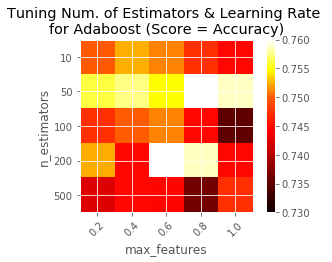

In [516]:
## Plot Validation Result
plt.figure(figsize=(5, 3))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_boost, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.73, midpoint=0.75))
plt.xlabel('max_features'); plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(values2_boost)), values2_boost, rotation=45)
plt.yticks(np.arange(len(values1_boost)), values1_boost)
plt.title('Tuning Num. of Estimators & Learning Rate \nfor Adaboost (Score = Accuracy)')
plt.show()

From the above image plot, the optimal parameter values for Adaboost are {number of estimators $NE = 50$ & learning rate $LR = 0.8$} or {$NE=200$ & $LR=0.6$}, while there are no clear patterns of optimal parameter convergence. We then refit these models on training set and use them to predict codes in test set. The outcomes will be used in the next subsection. Computation time for the estimation is presented below:

In [535]:
start = trec()
## Adaboost
boost1 = AdaBoostClassifier(random_state = 7899993, n_estimators = 50, learning_rate = 0.8)
## On Test Set
boost1fpr, boost1tpr, boost1rocauc, boost1prec, boost1rec, boost1prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, boost1)
time_boost1 = trec() - start
print('Computation time is %0.3f seconds' % time_boost1)

Computation time is 7.485 seconds


In [536]:
start = trec()
## Adaboost
boost2 = AdaBoostClassifier(random_state = 7899993, n_estimators = 200, learning_rate = 0.6)
## On Test Set
boost2fpr, boost2tpr, boost2rocauc, boost2prec, boost2rec, boost2prauc = gk.class_onestep_auc(X_train, y_train, X_test, y_test, boost2)
time_boost2 = trec() - start
print('Computation time is %0.3f seconds' % time_boost2)

Computation time is 20.261 seconds


##### All analytical results (except for lda function) are saved by following codes:

In [86]:
start = trec()

## List of Object to Save
objectlist = ['knn1', 'knn1fpr', 'knn1tpr', 'knn1rocauc', 'knn1prec', 'knn1rec', 'knn1prauc',
              'knn2', 'knn2fpr', 'knn2tpr', 'knn2rocauc', 'knn2prec', 'knn2rec', 'knn2prauc',
              'logit', 'logitfpr', 'logittpr', 'logitrocauc', 'logitprec', 'logitrec', 'logitprauc',
              'lda', 'ldafpr', 'ldatpr', 'ldarocauc', 'ldaprec', 'ldarec', 'ldaprauc',
              'svmcl', 'svmfpr', 'svmtpr', 'svmrocauc', 'svmprec', 'svmrec', 'svmprauc',
              'dt1', 'dt1fpr', 'dt1tpr', 'dt1rocauc', 'dt1prec', 'dt1rec', 'dt1prauc',
              'dt2', 'dt2fpr', 'dt2tpr', 'dt2rocauc', 'dt2prec', 'dt2rec', 'dt2prauc',
              'bag', 'bagfpr', 'bagtpr', 'bagrocauc', 'bagprec', 'bagrec', 'bagprauc',
              'rf', 'rffpr', 'rftpr', 'rfrocauc', 'rfprec', 'rfrec', 'rfprauc',
              'boost1', 'boost1fpr', 'boost1tpr', 'boost1rocauc', 'boost1prec', 'boost1rec', 'boost1prauc',
              'boost2', 'boost2fpr', 'boost2tpr', 'boost2rocauc', 'boost2prec', 'boost2rec', 'boost2prauc',
              'optparam_knn', 'optparam_logit', 'optparam_lda', 'optparam_svm',
              'optparam_dt', 'optparam_bag', 'optparam_rf', 'optparam_boost',
              'optscore_knn', 'optscore_logit', 'optscore_lda', 'optscore_svm',
              'optscore_dt', 'optscore_bag', 'optscore_rf', 'optscore_boost',
              'values_knn', 'values_lda', 'values_logit', 'values1_svm', 'values2_svm',  
              'values_dt','values_bag', 'values1_rf', 'values2_rf', 'values1_boost','values2_boost',
              'scores_knn', 'scores_logit', 'scores_lda', 'scores_svm',
              'scores_dt', 'scores_bag', 'scores_rf', 'scores_boost',
              'time_knn1', 'time_knn2', 'time_lda', 'time_logit', 'time_svm',
              'time_dt1', 'time_dt2', 'time_rf', 'time_bag', 'time_boost1', 'time_boost2']

## Save Objects
filename='../../data/STA208_Supervised_Learning_Result.db'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in objectlist:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 39.985 seconds


##### All analytical results can be restored by following codes: 

In [70]:
start = trec()

## Restore the Previous Session with Analytical Results
filename='../../data/STA208_Supervised_Learning_Result.db'
my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage = 0.8) ## only one object that cannot be saved

time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 16.423 seconds


## 3. Assess Classification Outcomes on Test Set

In this subsection, we assess the performence of classification methods on test-set, using paremeter values tuned in the previous subsection. In particular, we use ROC curve and Precision-Recall (PR) curve to evaluate performances. The assessment suggests that logistic regression and random forest are both computationally efficient and well performing methods.

### 3.1 ROC Curve

The following eight plots show ROC curves from the test-set predictions of supervised-learning methods with tuned parameter values.  

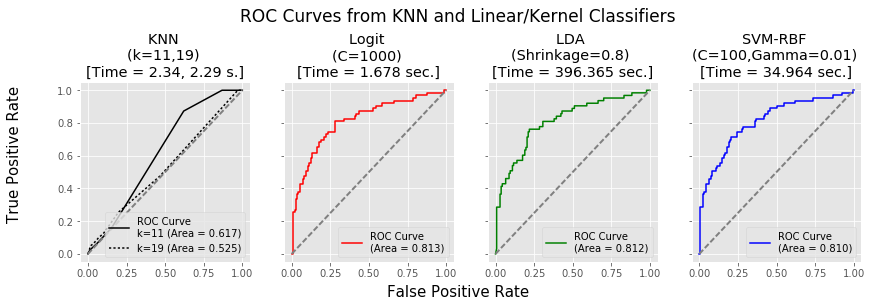

In [126]:
plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from KNN and Linear/Kernel Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(knn1fpr, knn1tpr, 'k-', label = 'ROC Curve \nk=11 (Area = %0.3f)' % knn1rocauc)
ax1.plot(knn2fpr, knn2tpr, 'k:', label = 'k=19 (Area = %0.3f)' % knn2rocauc)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('KNN \n(k=11,19) \n[Time = %0.2f, %0.2f s.]' % (time_knn1,time_knn2) )
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitfpr, logittpr, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('Logit \n(C=1000) \n[Time = %0.3f sec.]' %time_logit);
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(ldafpr, ldatpr, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % ldarocauc)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('LDA \n(Shrinkage=0.8) \n[Time = %0.3f sec.]' %time_lda);
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(svmfpr, svmtpr, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % svmrocauc)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('SVM-RBF \n(C=100,Gamma=0.01) \n[Time = %0.3f sec.]' %time_svm);
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")


plt.show()

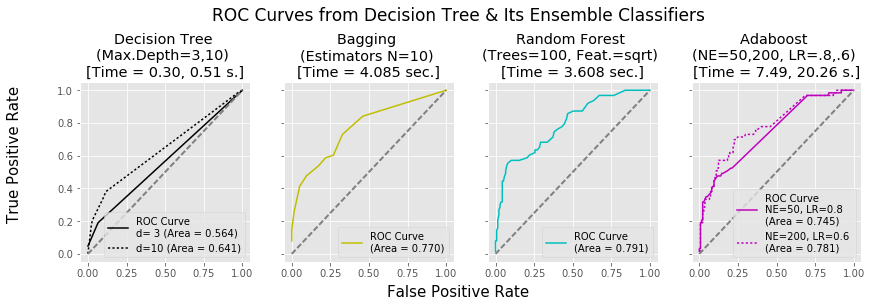

In [133]:
plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4),  = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'ROC Curves from Decision Tree & Its Ensemble Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(dt1fpr, dt1tpr, 'k-', label = 'ROC Curve \nd= 3 (Area = %0.3f)' % dt1rocauc)
ax1.plot(dt2fpr, dt2tpr, 'k:', label = 'd=10 (Area = %0.3f)' % dt2rocauc)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('Decision Tree \n(Max.Depth=3,10) \n[Time = %0.2f, %0.2f s.]' % (time_dt1,time_dt2));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(bagfpr, bagtpr, 'y-', label = 'ROC Curve \n(Area = %0.3f)' % bagrocauc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('Bagging \n(Estimators N=10) \n[Time = %0.3f sec.]' %time_bag);
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rffpr, rftpr, 'c-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('Random Forest \n(Trees=100, Feat.=sqrt) \n[Time = %0.3f sec.]' %time_rf);
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(boost1fpr, boost1tpr, 'm-', label = 'ROC Curve \nNE=50, LR=0.8\n(Area = %0.3f)' % boost1rocauc)
ax4.plot(boost2fpr, boost2tpr, 'm:', label = 'NE=200, LR=0.6 \n(Area = %0.3f)' % boost2rocauc)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('Adaboost \n(NE=50,200, LR=.8,.6) \n[Time = %0.2f, %0.2f s.]' % (time_boost1,time_boost2));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")


plt.show()

Comparing across the classification methods in the first row, KNN methods perform significantly worse than other three linear or kernel classification methods. Performances of logistic regression, LDA and SVM-RBF are roughly the same. Three methods have almost idential area under the ROC curve. On the other hand, computation time for the three methods varies significantly. While the fastest method, logit, finishes its estimation in 1.678 seconds, the slowest method, LDA takes more than six and half minutes to obtain the outcome. 

The second row presents the classification outcomes from decision tree and ensemble methods with decision tree. Here, all ensemble methods perform significantly better than the original decision tree method. Within ensemble methods, random forest does a slightly better job (larger area under ROC curve) than other two methods, and it is also faster than other two methods. In Adaboost, performance is better with higher number of estimators, while it comes with longer computation time. 

Comparing across first row and second row, logit, LDA and SVM-RBF performs better than random forest in terms of area under ROC curve. On the other hand, random forest does particularly good job in the early stage of prediction. In random forest, the false positive rate of prediction kept significatly low (under 10%) up untill the true positive rate reaches almost 60%. This is not the case for any of linear/kernel methods. 

### 3.2 Precision-Recall (PR) Curve

The following eight plots show Precision-Recall (PR) curves from the test-set predictions of supervised-learning methods with tuned parameter values.  

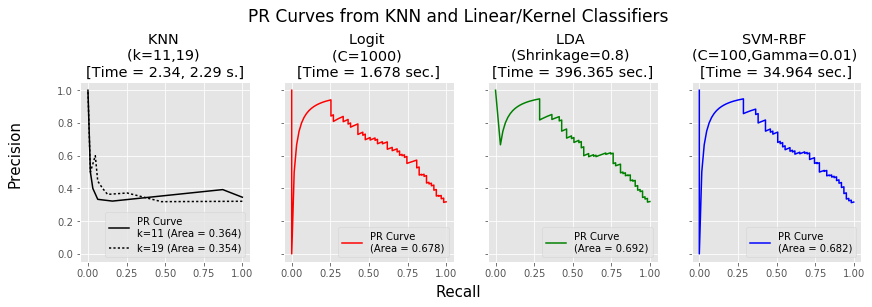

In [550]:
plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from KNN and Linear/Kernel Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(knn1rec, knn1prec, 'k-', label = 'PR Curve \nk=11 (Area = %0.3f)' % knn1prauc)
ax1.plot(knn2rec, knn2prec, 'k:', label = 'k=19 (Area = %0.3f)' % knn2prauc)
ax1.set_title('KNN \n(k=11,19) \n[Time = %0.2f, %0.2f s.]' % (time_knn1,time_knn2) )
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(logitrec, logitprec, 'r-', label = 'PR Curve \n(Area = %0.3f)' % logitprauc)
ax2.set_title('Logit \n(C=1000) \n[Time = %0.3f sec.]' %time_logit);
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(ldarec, ldaprec, 'g-', label = 'PR Curve \n(Area = %0.3f)' % ldaprauc)
ax3.set_title('LDA \n(Shrinkage=0.8) \n[Time = %0.3f sec.]' %time_lda);
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(svmrec, svmprec, 'b-', label = 'PR Curve \n(Area = %0.3f)' % svmprauc)
ax4.set_title('SVM-RBF \n(C=100,Gamma=0.01) \n[Time = %0.3f sec.]' %time_svm);
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

plt.show()

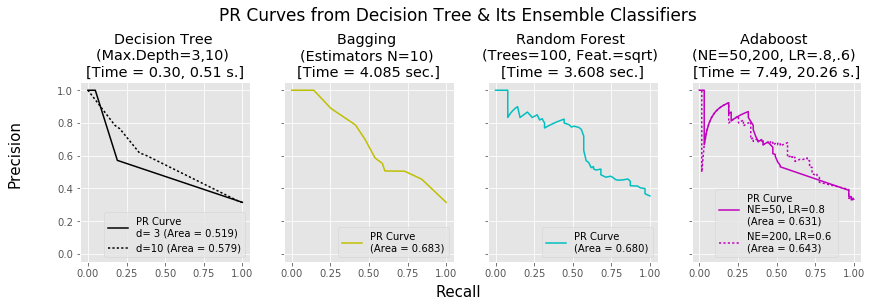

In [134]:
plt.rcParams["figure.figsize"] = (14,4)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.subplots_adjust(top = 0.75)
f.text(0.5, 0.98, 'PR Curves from Decision Tree & Its Ensemble Classifiers', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(dt1rec, dt1prec, 'k-', label = 'PR Curve \nd= 3 (Area = %0.3f)' % dt1prauc)
ax1.plot(dt2rec, dt2prec, 'k:', label = 'd=10 (Area = %0.3f)' % dt2prauc)
ax1.set_title('Decision Tree \n(Max.Depth=3,10) \n[Time = %0.2f, %0.2f s.]' % (time_dt1,time_dt2));
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(bagrec, bagprec, 'y-', label = 'PR Curve \n(Area = %0.3f)' % bagprauc)
ax2.set_title('Bagging \n(Estimators N=10) \n[Time = %0.3f sec.]' %time_bag);
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(rfrec, rfprec, 'c-', label = 'PR Curve \n(Area = %0.3f)' % rfprauc)
ax3.set_title('Random Forest \n(Trees=100, Feat.=sqrt) \n[Time = %0.3f sec.]' %time_rf);
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(boost1rec, boost1prec, 'm-', label = 'PR Curve \nNE=50, LR=0.8 \n(Area = %0.3f)' % boost1prauc)
ax4.plot(boost2rec, boost2prec, 'm:', label = 'NE=200, LR=0.6 \n(Area = %0.3f)' % boost2prauc)
ax4.set_title('Adaboost \n(NE=50,200, LR=.8,.6) \n[Time = %0.2f, %0.2f s.]' % (time_boost1,time_boost2));
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower center")

plt.show()

Comparing across the classification outcomes in first row, again, KNN performs significantly worse than other three methds. Within logit, LDA and SVM-RBF, LDA performs slightly better in terms of area under the curve (or average precision), while the shape of curve look almos identical for three methods. At the low range of recall rate, precision once drops significantly but backs up quickly to over 90%. Then after the recall rate goes above around 25%, the precision starts to decrease again, but this time gradually. In all three methods, precision at the recall rate of 100% is at around 30%.

In the second row, again, ensemble methods perfom significantly better than the original decision tree method. Again, the performance of random forest classification is comparable to that of linear/kernel classification method, but this time, bagging method performs as good as random forest (in terms of area under PR curve), and adaboost does the worst job in ensemble methods. At low range of recall rate (up untill around 60%), again, random forest does a particularly good job to keep precision high, at around 80%. Also, note that PR curves of bagging and random forest do not have a dip in precision at low range of recall rate, as it does in linear/kernel methods. PR curve for adaboost shows somewhat similar pattern as linear/kenel classification methods, as precision once drops significantly in the low range of recall rate.

### 3.3 Summary

In summary, all three linear/kernel methods (logit, LDA and SVM-RBF) perform similarly in the classification, while logistic regression is much more faster than other methods in estimating the outcome. For decision tree and relevant ensemble methods, random forest performs particularly well in the range of low recall rates. Also, random forest is faster in estimation than other ensemble methods. Therefore, in the next subsection, we use both logistic regression and random forest to predict negative sentiments in the full dataset. 

## 4. Predict Negative Sentiments in Full Dataset

In this subsection, we predict the negative sentiment appearance in full dataset. Logistic regression and random forest with tuned parameter values are used as the classifier, and ** *prediction is made as probability* **. We use probability, because we are interested in aggregate balance in (proportions of) sentiments, not the codes of each headline. To incorporate uncertainty in predictions, we train classifier on bootstrapped set of all coded data for 1000 times. We then assess the result briefly, and store predictions for the further usage.

### 4.1 Make Predictions of Negative Headline Probability

#### Logistic Regression

Codes and computation time are presented as follows:

In [596]:
start = trec()
probyav_logit, proby_logit = gk.class_simpred(targetx, X, y, logit, 1000)
time_logitpred = trec() - start
print('Computation time is %0.3f seconds' % time_logitpred)

Computation time is 9024.817 seconds


#### Random Forest

Codes and computation time are presented as follows:

In [597]:
start = trec()
probyav_rf, proby_rf = gk.class_simpred(targetx, X, y, rf, 1000)
time_rfpred = trec() - start
print('Computation time is %0.3f seconds' % time_rfpred)

Computation time is 9221.112 seconds


### 4.2 Asess Results

#### Relationship between Logit and Random Forest

The scatter plot below shows the relationship between predictions made by logit and random forest methods. Black dots represent actual mean predictions from each method, and red dashed line represent the hypotherical relationship where $\mbox{logit prediction} = \mbox{random forest prediction}$. Comparing red-line with black dots, it is clear that logit favor more extreme (close to 0 or 1) predictions compare to random forest. In general, logit predicts higher probability of negative sentiment than random forest. The simple regression line (blue dashed line) implies that logit predicts about 1.5 times higher probability of negative sentiment than random forest.

In [7]:
## Reload Neeeded Objects
#proby_logit = np.genfromtxt('../../data/logitpred_simulation_170529.csv.gz')
#proby_rf = np.genfromtxt('../../data/rfpred_simulation_170529.csv.gz')
#probyav_logit = np.mean(proby_logit, axis = 1)
#probyav_rf = np.mean(proby_rf, axis = 1)

In [37]:
# Correlation and Simple Linear Regression
corprobs = np.corrcoef(probyav_rf,probyav_logit)[0,1]
fitprobs = np.polyfit(probyav_rf,probyav_logit, deg=1)

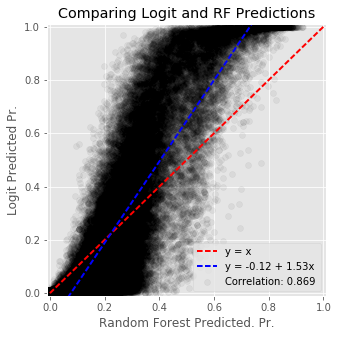

In [46]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(probyav_rf, probyav_logit, color = 'k', alpha=0.05, 
            label = 'Correlation: %0.3f' % corprobs)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--', label = 'y = x')
plt.plot([0, 1], [fitprobs[1], fitprobs[0] + fitprobs[1]], color='b', lw=2, 
         linestyle='--', label = 'y = %0.2f + %0.2fx ' %(fitprobs[1],fitprobs[0]))
plt.legend(loc="lower right")
plt.title('Comparing Logit and RF Predictions')
plt.xlabel('Random Forest Predicted. Pr.')
plt.ylabel('Logit Predicted Pr.')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

#### Uncertainty in Predictions

The table below shows standard errors from simulations from 1000 bootstrapped samples averaged by cases. It shows that random forest method have 0.05 smaller average standard error than logit. It confirms the expectation that the nature of random forest as ensemble method reduces the variance in predictions.   

In [156]:
pd.DataFrame({'Logit':np.mean(np.std(proby_logit, axis = 1)),
             'Random Forest':np.mean(np.std(proby_rf, axis = 1))}, 
             index = ['Average Standard Error'], 
             columns = ['Logit','Random Forest']).transpose()

,Average Standard Error
Logit,0.120296
Random Forest,0.070964


To further illustrate the above difference, following graph plots the upper and lower 95% confidence interval for the predictions for each headline case. X axis is just sorting the cases by ascending order of average prediction of each case, and y axis represent predicted probability. First, the average predicted probabilities are plotted as gray dashed line. Confirming the finding in the previous scatter plot, logit makes more extreme predictions than random forest. Logit prediction stays close to 0 up until first around 50,000 cases, and rise steeply after that. Second, red dots represent upper 95% confidence interval, and blue dots represent lower 95% confidence interval for the prediction of each case. It can be seen that logit prediction have generally wider confidence interval, particularly after the average prediction line becomes steeper. Random forest predictions, on the other hand, have relatively stable width of confidence interval across different levels of average prediction.

In [10]:
## Compute Confidence Interval
probyUpCI_logit = np.percentile(proby_logit, 97.5, axis = 1)
probyLoCI_logit = np.percentile(proby_logit, 2.5, axis = 1)
probyUpCI_rf = np.percentile(proby_rf, 97.5, axis = 1)
probyLoCI_rf = np.percentile(proby_rf, 2.5, axis = 1)

In [111]:
## Sorted Data
probyav_logit_sorted = probyav_logit[probyav_logit.argsort()]
probyUpCI_logit_sorted = probyUpCI_logit[probyav_logit.argsort()]
probyLoCI_logit_sorted = probyLoCI_logit[probyav_logit.argsort()]
probyav_rf_sorted = probyav_rf[probyav_rf.argsort()]
probyUpCI_rf_sorted = probyUpCI_rf[probyav_rf.argsort()]
probyLoCI_rf_sorted = probyLoCI_rf[probyav_rf.argsort()]

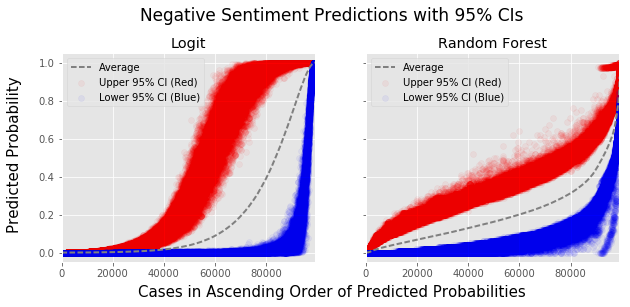

In [153]:
plt.rcParams["figure.figsize"] = (10,4)
f, (ax1, ax2),  = plt.subplots(1, 2, sharey=True)
f.subplots_adjust(top = 0.85)
f.text(0.5, 0.98, 'Negative Sentiment Predictions with 95% CIs', ha='center', va='center', fontsize = 17)
f.text(0.5, 0.02, 'Cases in Ascending Order of Predicted Probability', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Predicted Probability', ha='center', va='center', rotation='vertical', fontsize = 15)

ax1.plot(range(1,len(probyav_logit)+1), probyav_logit_sorted, color='gray', lw=2, linestyle='--', label = "Average")
ax1.scatter(range(1,len(probyav_logit)+1), probyUpCI_logit_sorted, color = 'r', alpha=0.05, label = "Upper 95% CI (Red)")
ax1.scatter(range(1,len(probyav_logit)+1), probyLoCI_logit_sorted, color = 'b', alpha=0.05, label = "Lower 95% CI (Blue)")
ax1.set_title('Logit')
ax1.set_xlim(-1,len(probyav_rf)+1)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="upper left")

ax2.plot(range(1,len(probyav_rf)+1), probyav_rf_sorted, color='gray', lw=2, linestyle='--', label = "Average")
ax2.scatter(range(1,len(probyav_rf)+1), probyUpCI_rf_sorted, color = 'r', alpha=0.05, label = "Upper 95% CI (Red)")
ax2.scatter(range(1,len(probyav_rf)+1), probyLoCI_rf_sorted, color = 'b', alpha=0.05, label = "Lower 95% CI (Blue)")
ax2.set_title('Random Forest')
ax2.set_xlim(-1,len(probyav_rf)+1)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="upper left")

plt.show()

### 4.3 Export Result as CSV file

* Average predicted proabability are stored as new variables --- <code>logit_pred</code> for logistic regression prediction and <code>rf_pred</code> for random forest prediction --- in <code>alldata</code> dataset. New dataset is saved to <code>../../data/alldata_codepred_170529.csv</code>. Corresponding codes and computation time are provided as follows:

In [598]:
start = trec()

## Save Average Coding
alldata['logit_pred'] = probyav_logit
alldata['rf_pred'] = probyav_rf
alldata.to_csv(path_or_buf = '../../data/alldata_codepred_170529.csv', encoding='CP932')

time_saveav = trec() - start
print('Computation time is %0.3f seconds' % time_saveav)

Computation time is 3.246 seconds


* Simulation result for logistic regression prediction is independently saved to <code>../../data/logitpred_simulation_170529.csv.gz</code>. This file is large and violating the file size limit in GitHub, so not uploaded to the project website. Corresponding codes and computation time are provided as follows:

In [599]:
start = trec()

## Save Logit Prediction Simulation
np.savetxt('../../data/logitpred_simulation_170529.csv.gz', proby_logit)

time_saveprobylogit = trec() - start
print('Computation time is %0.3f seconds' % time_saveprobylogit)

Computation time is 717.862 seconds


* Simulation result for logistic regression prediction is independently saved to <code>../../data/rfpred_simulation_170529.csv.gz</code>. This file is large and violating the file size limit in GitHub, so not uploaded to the project website. Corresponding codes and computation time are provided as follows:

In [600]:
start = trec()

## Save Random Forest Prediction Simulation
np.savetxt('../../data/rfpred_simulation_170529.csv.gz', proby_rf)

time_saveprobyrf = trec() - start
print('Computation time is %0.3f seconds' % time_saveprobyrf)

Computation time is 689.503 seconds
